# Testing the Performance of Coin Model at Low C Rate

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Note: you may need to restart the kernel to use updated packages.


In [2]:
chemistry = pybamm.parameter_sets.Ecker2015_v2
var = pybamm.standard_spatial_vars

In [3]:
coin = {"particle shape":"negative coin"}

Model 1, DFN coin

In [4]:
# choose DFN
model1 = pybamm.lithium_ion. DFN(build=False, options=coin)
# add rho_n
model1.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model1.param.R_n,
    }
)
# delete r_n
model1.variables.pop('r_n', None)
model1.variables.pop('r_n [m]', None)
model1.build_model()

Model 2, SPMe coin

In [5]:
# choose SPMe
model2 = pybamm.lithium_ion. SPMe(build=False, options=coin)
# add rho_n
model2.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model2.param.R_n,
    }
)
# delete r_n
model2.variables.pop('r_n', None)
model2.variables.pop('r_n [m]', None)
model2.build_model()

Model 3, DFN spherical

Model 4, SPMe spherical

In [6]:
# choose DFN
model3 = pybamm.lithium_ion.DFN()
# choose SPMe
model4 = pybamm.lithium_ion.SPMe()

Parameter set 1, coin

In [7]:
# pick parameters, keeping C-rate as an input to be changed for each solve
parameter_values1 = pybamm.ParameterValues(chemistry=chemistry)
parameter_values1.update({"Current function [A]": "[input]"})
parameter_values1.update({"Negative particle radius [m]": 2.1e-05})
parameter_values1.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin_4"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry['anode'])

Parameter set 2, spherical

In [8]:
parameter_values2 = pybamm.ParameterValues(chemistry=chemistry)
parameter_values2.update({"Current function [A]": "[input]"})
parameter_values2.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_up"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry['anode'])

In [9]:
# coin
var_pts1 = {
    var.x_n: int(parameter_values1.evaluate(model2.param.L_n / 1e-6)),
    var.x_s: int(parameter_values1.evaluate(model2.param.L_s / 1e-6)),
    var.x_p: int(parameter_values1.evaluate(model2.param.L_p / 1e-6)),
    var.rho_n: int(parameter_values1.evaluate(model2.param.R_n / 1e-7)),
    var.r_p: int(parameter_values1.evaluate(model2.param.R_p / 1e-7)),
}
# spherical
var_pts2 = {
    var.x_n: int(parameter_values2.evaluate(model4.param.L_n / 1e-6)),
    var.x_s: int(parameter_values2.evaluate(model4.param.L_s / 1e-6)),
    var.x_p: int(parameter_values2.evaluate(model4.param.L_p / 1e-6)),
    var.r_n: int(parameter_values2.evaluate(model4.param.R_n / 1e-7)),
    var.r_p: int(parameter_values2.evaluate(model4.param.R_p / 1e-7)),
}

In [10]:
sim1 =  pybamm.Simulation(model2, parameter_values=parameter_values1, var_pts=var_pts1, geometry=pybamm.battery_geometry(coin_geometry=True))
sim2 =  pybamm.Simulation(model4, parameter_values=parameter_values2, var_pts=var_pts2)

## Pseudo-OCV

In [11]:
C_rates = [1/20, 1]  # C-rates to solve for
capacity = parameter_values1["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 100800, 10000), 
    np.linspace(0, 4000, 100)
] # times to return the solution at
solutions1 = [None] * len(C_rates)  # empty list that will hold solutions
current1 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions1[i] = sim1.solution    
    current1 = np.append(current1, current)

In [12]:
C_rates = [1/20, 1]  # C-rates to solve for
capacity = parameter_values2["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 100800, 10000), 
    np.linspace(0, 3800, 100)
] # times to return the solution at
solutions2 = [None] * len(C_rates)  # empty list that will hold solutions
current2 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions2[i] = sim2.solution    
    current2 = np.append(current2, current)

In [13]:
# load ocv data
voltage_data = pd.read_csv("pybamm/input/discharge_data/Ecker_OCV1.csv", header=None).to_numpy()

2020-08-26 18:16:26,151 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:16:57,389 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


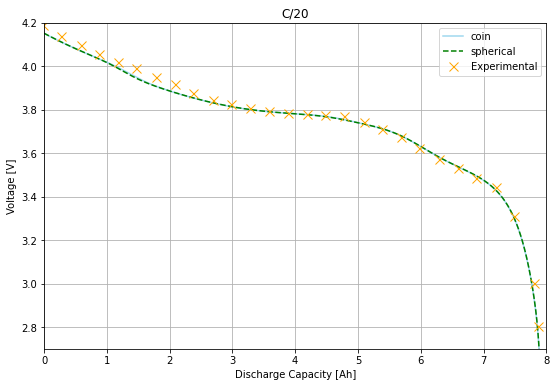

In [14]:
plt.figure(figsize=[9,6])
ax = plt.gca()
ax.spines['bottom'].set_position(['data',2.7])
ax.spines['left'].set_position(['data',0])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the C/20 results
t_sol1 = solutions1[0]["Time [s]"].entries
t_sol2 = solutions2[0]["Time [s]"].entries
ax.plot((current1[0] * t_sol1 * 48)/3600, solutions1[0]["Terminal voltage [V]"](t_sol1), label="coin", color="skyblue", alpha=0.8)
ax.plot((current2[0] * t_sol2 * 48)/3600, solutions2[0]["Terminal voltage [V]"](t_sol2), label="spherical", color="green", linestyle='--')
ax.plot(voltage_data[:,0], voltage_data[:,1], marker="x", color='orange', label='Experimental', markersize=9, linestyle='')
ax.set_xlabel("Discharge Capacity [Ah]")
ax.set_ylabel("Voltage [V]")
ax.set_title("C/20")
ax.legend(loc="best")
ax.grid()

plt.xlim(0,8)
plt.ylim(2.7,4.2)
#plt.savefig('OCV')
plt.show()

2020-08-26 18:16:58,878 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


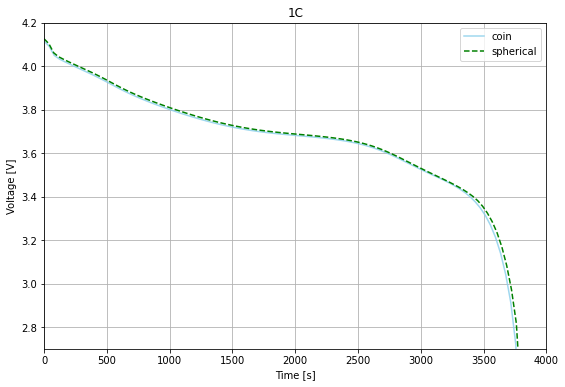

In [15]:
plt.figure(figsize=[9,6])
ax = plt.gca()
ax.spines['bottom'].set_position(['data',2.7])
ax.spines['left'].set_position(['data',0])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the C/20 results
t_sol1 = solutions1[1]["Time [s]"].entries
t_sol2 = solutions2[1]["Time [s]"].entries
ax.plot(t_sol1, solutions1[1]["Terminal voltage [V]"](t_sol1), label="coin", color="skyblue", alpha=0.8)
ax.plot(t_sol2, solutions2[1]["Terminal voltage [V]"](t_sol2), label="spherical", color="green", linestyle='--')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.set_title("1C")
ax.legend(loc="best")
ax.grid()

plt.xlim(0,4000)
plt.ylim(2.7,4.2)
#plt.savefig('OCV')
plt.show()

## Varying C-rate

In [16]:
C_rates = [0.25, 1, 3, 5]  # C-rates to solve for
capacity = parameter_values1["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 20000, 1000),
    np.linspace(0, 5000, 100),
    np.linspace(0, 2500, 100),
    np.linspace(0, 1000, 100)
]
solutions3 = [None] * len(C_rates)  # empty list that will hold solutions
current3 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions3[i] = sim1.solution
    current3 = np.append(current3, current)

In [17]:
C_rates = [0.25, 1, 3, 5]  # C-rates to solve for
capacity = parameter_values2["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 20000, 1000),
    np.linspace(0, 5000, 100),
    np.linspace(0, 2000, 100),
    np.linspace(0, 720, 100)
]
solutions4 = [None] * len(C_rates)  # empty list that will hold solutions
current4 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions4[i] = sim2.solution
    current4 = np.append(current4, current)

2020-08-26 18:26:29,372 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:26:29,380 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:26:29,386 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:26:29,390 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:26:29,394 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:26:29,398 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-26 18:26:29,404 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


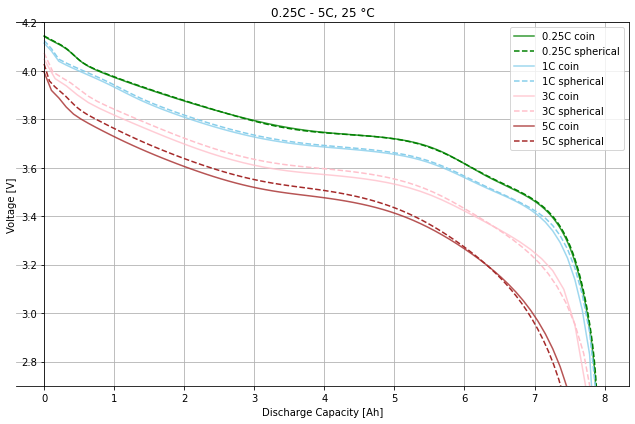

In [19]:
plt.figure(figsize=[9,6])
ax = plt.gca()
ax.spines['bottom'].set_position(['data',2.7])
ax.spines['left'].set_position(['data',0])
# plot the 0.25C - 5C results
t_sol1c = solutions3[0]["Time [s]"].entries
t_sol1s = solutions4[0]["Time [s]"].entries
t_sol2c = solutions3[1]["Time [s]"].entries
t_sol2s = solutions4[1]["Time [s]"].entries
t_sol3c = solutions3[2]["Time [s]"].entries
t_sol3s = solutions4[2]["Time [s]"].entries
t_sol4c = solutions3[3]["Time [s]"].entries
t_sol4s = solutions4[3]["Time [s]"].entries
ax.plot((current3[0] * t_sol1c * 48)/3600, solutions3[0]["Terminal voltage [V]"](t_sol1c), label="0.25C coin", color="green", alpha=0.8)
ax.plot((current4[0] * t_sol1s * 48)/3600, solutions4[0]["Terminal voltage [V]"](t_sol1s), label="0.25C spherical", color="green", linestyle='--')
ax.plot((current3[1] * t_sol2c * 48)/3600, solutions3[1]["Terminal voltage [V]"](t_sol2c), label="1C coin", color="skyblue", alpha=0.8)
ax.plot((current4[1] * t_sol2s * 48)/3600, solutions4[1]["Terminal voltage [V]"](t_sol2s), label="1C spherical", color="skyblue", linestyle='--')
ax.plot((current3[2] * t_sol3c * 48)/3600, solutions3[2]["Terminal voltage [V]"](t_sol3c), label="3C coin", color="pink", alpha=0.8)
ax.plot((current4[2] * t_sol3s * 48)/3600, solutions4[2]["Terminal voltage [V]"](t_sol3s), label="3C spherical", color="pink", linestyle='--')
ax.plot((current3[3] * t_sol4c * 48)/3600, solutions3[3]["Terminal voltage [V]"](t_sol4c), label="5C coin", color="brown", alpha=0.8)
ax.plot((current4[3] * t_sol4s * 48)/3600, solutions4[3]["Terminal voltage [V]"](t_sol4s), label="5C spherical", color="brown", linestyle='--')
ax.set_xlabel("Discharge Capacity [Ah]")
ax.set_ylabel("Voltage [V]")
ax.set_title("0.25C - 5C, 25 °C")
ax.legend(loc="best")
ax.grid()

plt.ylim(2.7,4.2)
plt.tight_layout()
#plt.savefig("Changing C-rate at 25 degrees")
plt.show()